# Initial anaysis of the scale sensor data

Import libraries to use in the project

In [1]:
import pandas as pd
import numpy as np
import os

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#from fbprophet import Prophet

from datetime import datetime, timedelta

#from pmdarima.arima import auto_arima


Here we read the csv data

In [2]:
brew_data_df = pd.read_csv(os.path.join('data', '75556_brewmaster2_20210130201004_BZPJPluH5p.csv'),parse_dates=['createdAt'])
brew_data_df = brew_data_df.drop(columns=['temperature', 'grind', 'note'])

In [3]:
brew_data_df

,id,name,createdAt,tasty,total time,average flowrate,total weight,brew data
0,7aLdTgeEWX,157,2021-01-30 19:12:38,4,2535,36.53,109.599998,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
1,svIHr0vdP4,156,2021-01-30 18:13:01,4,3373,92.67,278.000000,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
2,AT6LzAnzgJ,155,2021-01-30 18:03:08,4,361,7.07,49.500000,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
3,wDscJtnyMU,154,2021-01-29 19:14:18,4,1260,17.46,122.199997,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
4,FomU4RCCc5,153,2021-01-29 18:05:35,4,1659,26.57,79.699997,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
...,...,...,...,...,...,...,...,...
171,GIhIPyhIFh,hello2,2020-02-24 18:58:56,4,966,7.14,35.700001,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
172,QOnLyVtLAC,hello,2020-02-24 16:16:50,4,4359,27.66,193.600006,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...
173,I37RdnKrTS,test,2019-11-06 16:58:52,4,3864,32.80,196.800003,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.90;0...
174,UDaUHwzMye,test,2019-11-06 16:17:44,4,1598,8.55,17.100000,0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0.00;0...


In [4]:
brew_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                176 non-null    object        
 1   name              176 non-null    object        
 2   createdAt         176 non-null    datetime64[ns]
 3   tasty             176 non-null    int64         
 4   total time        176 non-null    int64         
 5   average flowrate  176 non-null    float64       
 6   total weight      176 non-null    float64       
 7   brew data         176 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 11.1+ KB


In [5]:
brew_data_df['createdAt'].min(), brew_data_df['createdAt'].max()

(Timestamp('2019-10-16 21:31:22'), Timestamp('2021-01-30 19:12:38'))

### Convert to time series

In [5]:
samplings = []

for id_,ex in brew_data_df.iterrows():
    data= ex['brew data'].split(';') 
    s= len(data)/ex['total time']
    if s < 20:
        samplings.append(s)
print(f"Mean sampling rate {np.mean(samplings)}")

Mean sampling rate 6.043230295971351


In [6]:
#f, axes = plt.subplots(brew_data_df.shape[0], 1, figsize=(200,40), sharey='row', sharex='col')
#axe = axes.ravel()

i=0
time_series = []
filtered_time_series = []
time_lengths = []
init_hours = {}
final_hours = {}

for id_,ex in brew_data_df.iterrows():
    data= ex['brew data'].split(';')
    data_num = [float(d) for d in data[:-1]]
    
    start_date = ex['createdAt']

    freq= "S"
    if len(data) < 5000:
        freq= "3S"
    elif (len(data)>5000) and (len(data)< 10000):
        freq= "2S"
        
    ts_index = start_date + pd.timedelta_range(0, periods=len(data)-1, freq=freq)
    ts= pd.Series(data_num, index=ts_index)
    time_series.append(ts)
    
    h= ts.index[0].hour
    ih = init_hours.get(h,0)
    ih += 1
    init_hours[h]=ih
    
    h= ts.index[-1].hour
    fh = final_hours.get(h,0)
    fh += 1
    final_hours[h]=fh
    
    time_lengths.append((ts.index[-1]-ts.index[0]).seconds)
    
    ts_parts= seasonal_decompose(ts, model='additive', period=60)
    filtered_time_series.append(ts_parts.trend.fillna(0))

In [7]:
def generate_hour_plot_fn(hour_dict, hour_type):
    for h in range(0,23):
        v = hour_dict.get(h,0)
        hour_dict[h]=v
    df = pd.DataFrame.from_dict(hour_dict, orient='index')
    df = df.sort_index()
    
    ax=df.plot(kind='bar', grid=True, legend=False)
    ax.set_xlabel(f'{hour_type} hour of the experiment');
    ax.set_ylabel('Number of experiments');
    plt.tight_layout()
    plt.savefig(os.path.join('figs',f"{hour_type}_time_experiments.png"))
    
    return df

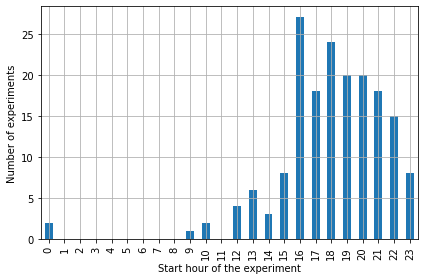

In [8]:
init_hours_df= generate_hour_plot_fn(init_hours, 'Start')

In [9]:
init_hours_df.head()

,0
0,2
1,0
2,0
3,0
4,0


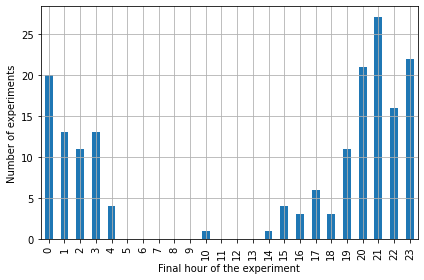

In [10]:
final_hours_df= generate_hour_plot_fn(final_hours, 'Final')

In [11]:
final_hours_df.head()

,0
0,20
1,13
2,11
3,13
4,4


In [12]:
#average_timedelta = sum(time_lengths, timedelta(0)) / len(time_lengths)

print(f"Avg. length of the series {np.mean(time_lengths)/60}")
print(f"Std. length of the series {np.std(time_lengths)/60}")


Avg. length of the series 235.1784090909091
Std. length of the series 65.48652919536099


In [13]:
def extract_num_items(ts):
    prev_value= 0
    prev_t = None
    n_items =0
    n_usages =0
    for t, v in ts.iteritems():
        if prev_t is None:
            prev_t = t
            prev_value= v
        elif ((v - prev_value)>10):
            #print(v, prev_value, t, prev_t, (t-prev_t).seconds)
            n_items += 1
            prev_value= v
            if (t-prev_t).seconds > 300:
                n_usages +=1
                prev_t= t
    return n_usages, n_items

In [14]:
ts_features = []
for ts in filtered_time_series:
    m = ts.mean()
    q25 = ts.quantile(0.25)
    q75= ts.quantile(0.75)
    usages, items = extract_num_items(ts)
    ts_features.append((m,q25,q75,usages,items))

In [15]:
ts_features_df = pd.DataFrame(ts_features, columns='mean q25 q75 usages items'.split())

In [16]:
ts_features_df.head()

,mean,q25,q75,usages,items
0,28.993665,0.000000,46.900000,3,8
1,68.185021,45.785000,102.800000,4,11
2,31.089471,0.000000,48.758333,1,4
3,53.092575,39.101875,98.080833,4,11
4,55.228051,0.000833,76.620833,1,7


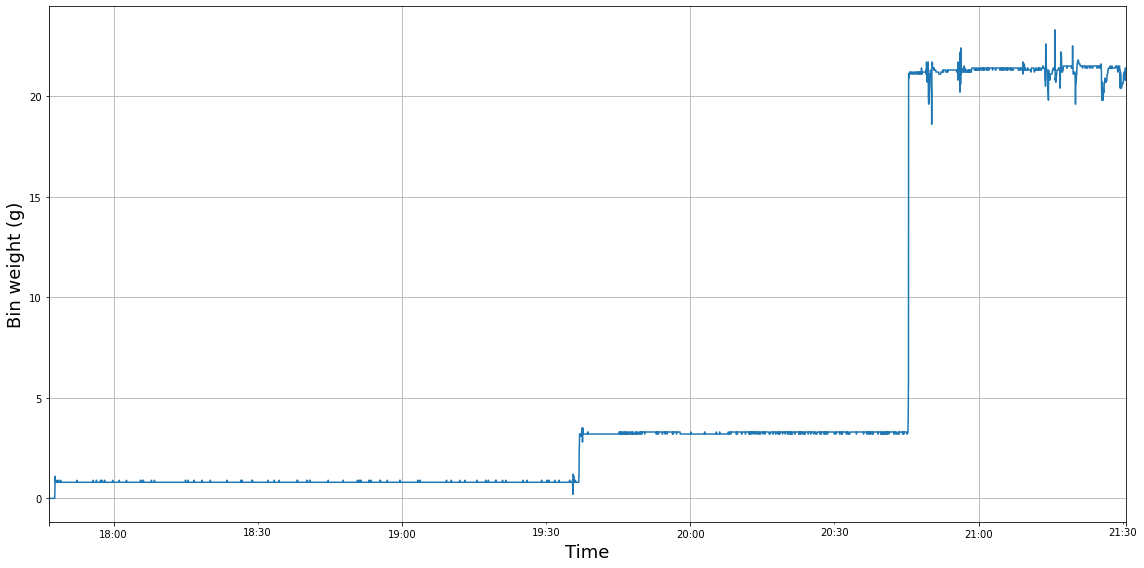

In [17]:
ax=time_series[82].plot(figsize=(16,8), grid=True);
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Bin weight (g)', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join('figs','ts_example.png'))

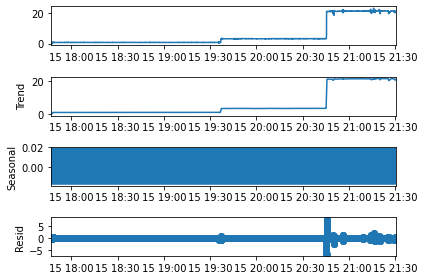

In [18]:
seasonal_decompose(time_series[82], model='additive', period=30).plot()
plt.tight_layout()
plt.savefig(os.path.join('figs','ts_example_decomp.png'))

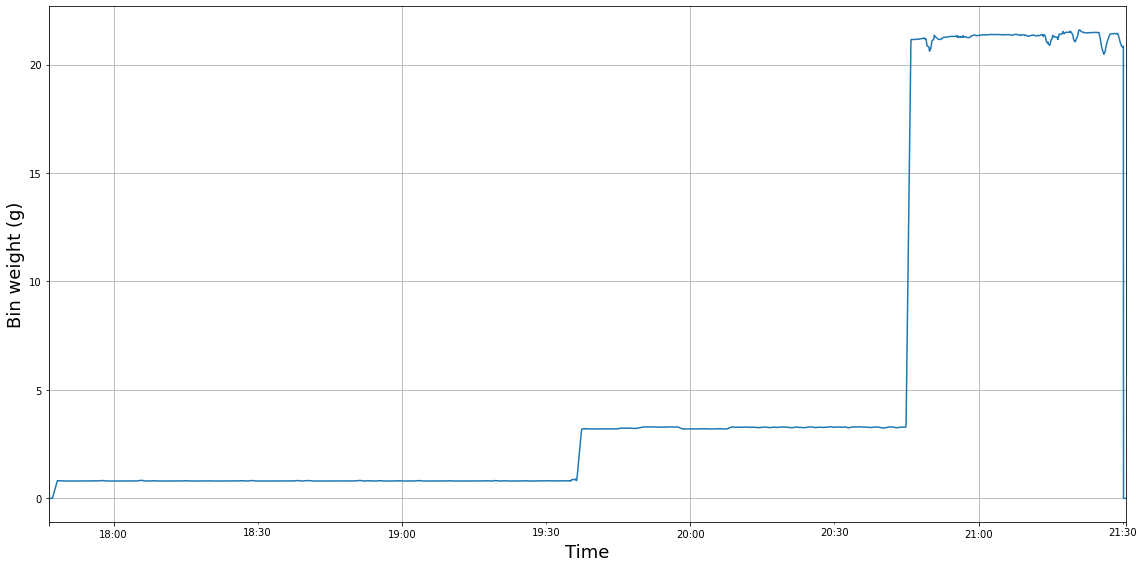

In [19]:
ax=filtered_time_series[82][:-1].plot(figsize=(16,8), grid=True);
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Bin weight (g)', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join('figs','ts_example_filtered.png'))

## Generate clusters of time series

In [20]:
from sklearn.cluster import KMeans

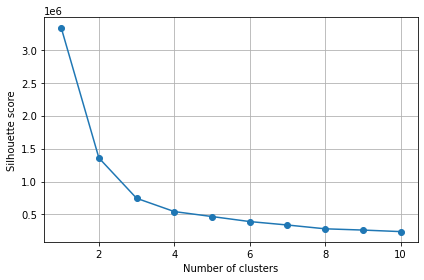

In [21]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(ts_features_df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.tight_layout()
plt.savefig(os.path.join('figs', 'sil_score.png'))
plt.show()


In [22]:
km = KMeans(n_clusters=3)
y_km = km.fit_predict(ts_features_df)

In [23]:
km.cluster_centers_

array([[129.64105306,  74.83195602, 188.94940972,   4.09259259,
         21.51851852],
       [ 47.37317051,  22.38555237,  72.39039373,   2.4587156 ,
          8.7706422 ],
       [274.40662767, 188.86310897, 398.44197115,   4.38461538,
         38.92307692]])

In [25]:
len(km.labels_)

176

In [26]:
brew_data_df['cluster']= km.labels_

In [27]:
brew_data_df.to_csv(os.path.join('data', 'brew_data_with_label.csv'))

## Prediction mechanisms

# Prophet

We focus on one experiment

In [ ]:
data= brew_data_df[brew_data_df['id']=='a9PSHhDkbr']['brew data'].values[0].split(';')

Prepare the data for propeth

In [ ]:
data_num = [float(d) for d in data[:-1]]
df = pd.DataFrame(data=data_num, columns=['y'])

In [ ]:
delta = timedelta(microseconds=20000)

times = []
now= datetime.today()

#current time
for i in range(0, df.shape[0]):
    times.append(now)#.strftime('%H:%M:%S'))
    now += delta

#times to predict
future = []
for i in range(0, 10000):
    future.append(now)#.strftime('%H:%M:%S'))
    now += delta   

In [ ]:
df['ds'] = times

In [ ]:
df.tail()

In [ ]:
# define the model
model = Prophet()
# fit the model
model.fit(df);

In [ ]:
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)

In [ ]:
model.plot(forecast)
plt.show()

## Auto ARIMA

https://github.com/mkosaka1/AirPassengers_TimeSeries/blob/master/Time_Series.ipynb

In [ ]:
df_ts = df.set_index('ds')

In [ ]:
df_ts.shape[0]

In [ ]:
train = df_ts[:18000]
test = df_ts[18000:]

In [ ]:
train

In [ ]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

In [ ]:
model.summary()


In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = 30),index=test.index)
prediction.columns = ['predicted_passengers']
prediction

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
print("That's all folks")